In [1]:
import os, re 
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def get_results_dir(model_name, dataset_name, model_type, fault_type):
    d = {
        'vgg16': {
            'cifar10': {
                'full': {
                    'faults_layer_rb': './logs/vgg16/cifar10/int8/faults_layer_rb',
                    'faults_layer_rb_ps1': './logs/vgg16/cifar10/int8/faults_layer_rb_ps1',
                },
               
            }
        }
        
    }
    return d.get(model_name).get(dataset_name).get(model_type).get(fault_type)

def get_fault_free_accuracy(model_name, dataset_name, model_type):
    d = {'vgg16': {
        'cifar10': {
            'full': 0.9375, 
          }},
        }
        
    return d[model_name][dataset_name][model_type]

model_name = 'vgg16'
dataset_name = 'cifar10'

model_types = ['full']
fault_types = ['faults_layer_rb', 'faults_layer_rb_ps1']
# fault_types = ['faults_layer', 'faults_layer_masking']


In [3]:
def parse_log(log_path):
    # trial: 9, bit_position: 0, n_faults: 1, total_params: 1728, 
    # flipped_bits: 1 (1.808449e-05), changed_params: 1 (5.787037e-04), test_time: 2, test_accuracy: 0.938800
    result = {}
    with open(log_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            if line:
                flipped_bits, changed_params, test_accuracy = 0, 0, None 
                items = line.split(',')
                for item in items:
                    if 'total_params' in item:
                        total_params = int(item.split()[1])
                    if 'changed_params' in item:
                        changed_params = int(item.split()[1])
                    if 'test_accuracy' in item:
                        test_accuracy = float(item.split()[1])
                    if 'trial' in item:
                        trial = int(item.split()[1])
                if test_accuracy:
                    result[trial] = [total_params, changed_params, test_accuracy]
    result = np.asarray([result[trial_id] for trial_id in sorted(result.keys())])
    return result 

def load_results(model_type, fault_type):
    results = {}
    results_dir = get_results_dir(model_name, dataset_name, model_type, fault_type)
    if not results_dir:
        return None 
    
    # ./cifar/l1-norm-pruning/logs/vgg16/cifar10/faults_layer/param-0/bit-0/nbits-1
    param_id_folders = os.listdir(results_dir)
    for param_id_folder in param_id_folders:
        param_id = int(param_id_folder.split('-')[-1])
        param_id_path = os.path.join(results_dir, param_id_folder)
        if param_id not in results:
            results[param_id] = {} 
        
        # get number of bits folder
        for nbits_folder in os.listdir(param_id_path):
            nbits = float(nbits_folder[2:])
            log_path = os.path.join(param_id_path, nbits_folder, 'logs.txt')
            if os.path.isfile(log_path):
                results[param_id][nbits] = parse_log(log_path)
    return results 
        
data = {} # model_type -> fault_type -> param_id -> bit_position -> n_bits 
for model_type in model_types:
    data[model_type] = {} 
    for fault_type in fault_types:
        results = load_results(model_type, fault_type)
        if results:
            data[model_type][fault_type] = results 

param_id = 0 
print(data[model_type][fault_type][param_id][0.1].shape)


(10, 3)


In [4]:
import torch 

model_path = './logs/'+ model_name +'/' + dataset_name +'/int8/quantized.pth.tar'
checkpoint = torch.load(model_path)
prec1 = checkpoint['prec1']
print('prec1:', prec1)
state_dict = checkpoint['state_dict']
param_id_to_name = {}
param_id_to_shape = {} 
param_id = 0 
weights_id = []

for key in state_dict:
    tensor = state_dict[key]
    if len(tensor.size()) >= 2:
        weights_id.append(param_id)
        param_id_to_shape[param_id] = tuple(tensor.size())
        
    if 'weight' in key or 'bias' in key:
        param_id_to_name[param_id] = key
        param_id += 1
    if len(tensor.size()) < 2:
        continue
#     minv, maxv = tensor.min().item(), tensor.max().item() 
#     tensor = tensor.cpu().numpy().ravel()
#     print([int(x) for x in tensor[:50]])
#     plt.hist(tensor, bins=100)
# #     plt.plot(tensor.cpu().numpy().ravel())
#     zeros = sum([x==0 for x in tensor])
#     plt.title(key+' [%d, %d], zero:%.2f' %(minv, maxv, zeros/len(tensor)))
#     plt.show()

prec1: 0.9375


In [5]:
print(len(param_id_to_name))
for weight_id in weights_id:
    print('layer_id:', weight_id//3, 
          ', shape:', param_id_to_shape[weight_id], 
          ', #values:', np.prod(param_id_to_shape[weight_id]))

45
layer_id: 0 , shape: (64, 3, 3, 3) , #values: 1728
layer_id: 1 , shape: (64, 64, 3, 3) , #values: 36864
layer_id: 2 , shape: (128, 64, 3, 3) , #values: 73728
layer_id: 3 , shape: (128, 128, 3, 3) , #values: 147456
layer_id: 4 , shape: (256, 128, 3, 3) , #values: 294912
layer_id: 5 , shape: (256, 256, 3, 3) , #values: 589824
layer_id: 6 , shape: (256, 256, 3, 3) , #values: 589824
layer_id: 7 , shape: (512, 256, 3, 3) , #values: 1179648
layer_id: 8 , shape: (512, 512, 3, 3) , #values: 2359296
layer_id: 9 , shape: (512, 512, 3, 3) , #values: 2359296
layer_id: 10 , shape: (512, 512, 3, 3) , #values: 2359296
layer_id: 11 , shape: (512, 512, 3, 3) , #values: 2359296
layer_id: 12 , shape: (512, 512, 3, 3) , #values: 2359296
layer_id: 13 , shape: (512, 512) , #values: 262144
layer_id: 14 , shape: (10, 512) , #values: 5120


In [6]:
# print(data)

[0.0001, 0.001, 0.01, 0.1]
[1e-05, 0.0001, 0.001, 0.01, 0.1]
[1e-05, 0.0001, 0.001, 0.01, 0.1]
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]


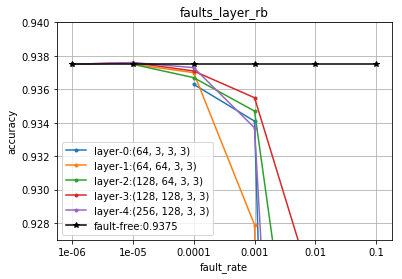

[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]
[1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]
[1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]


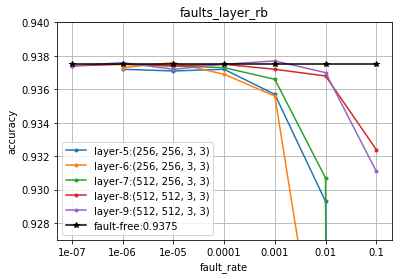

[1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]
[1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]
[1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]
[0.0001, 0.001, 0.01, 0.1]


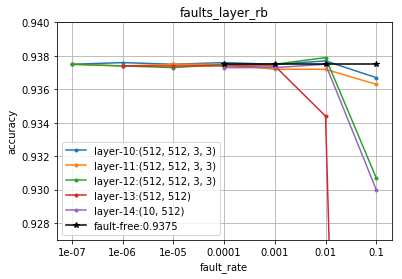

[0.0001, 0.001, 0.01, 0.1]
[1e-05, 0.0001, 0.001, 0.01, 0.1]
[1e-05, 0.0001, 0.001, 0.01, 0.1]
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]


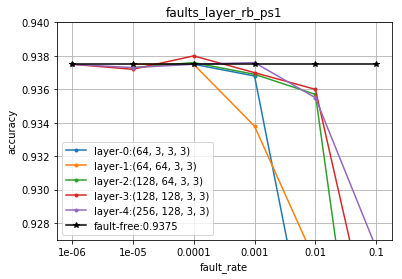

[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]
[1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]
[1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]


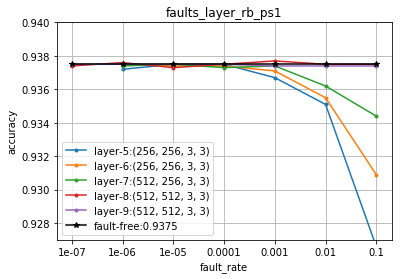

[1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]
[1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]
[1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]
[0.0001, 0.001, 0.01, 0.1]


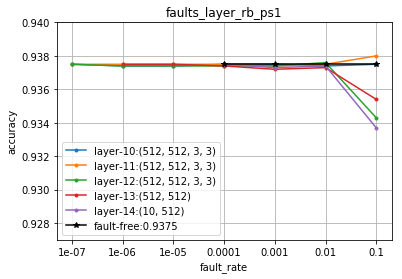

In [7]:
# x: fault_rate, y:accuracy; lengends: param_id 

for model_type in model_types:
    fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, model_type)
    for fault_type in fault_types:
        xticks = ([], []) 
        for param_id in sorted(data[model_type][fault_type].keys()):
            if param_id not in weights_id:
                continue 

            res = data[model_type][fault_type][param_id]
            fault_rates = sorted(res.keys())
            print(fault_rates)
            num_values = res[fault_rates[0]][0, 0]
            x = np.log10(fault_rates)

            accuracies = [np.min(res[n_bits], axis=0)[2] for n_bits in fault_rates]
            plt.plot(x, accuracies, 
                     label='layer-%d:%s' %(param_id//3, param_id_to_shape[param_id]), marker='.')
            if len(xticks[0]) < len(x):
                xticks = (x, [s for s in map(str, fault_rates)])
            
            if param_id in [12, 27, 43]:
                plt.ylim(0.927, 0.94)
                
        #             plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
                plt.grid()
                plt.ylabel('accuracy')
                plt.xlabel('fault_rate')
                plt.title('%s' %(fault_type))
                plt.xticks(xticks[0], xticks[1])
                plt.plot(x, [fault_free_accuracy]*len(x), marker='*', color='k', 
                         label='fault-free:%.4f' %(fault_free_accuracy))
                plt.legend()    
                plt.show()


layer_id: 0, #values: 1728
fault_type fault_rate      0      1      2      3      4      5      6      7      8      9
        rb     0.0001 0.9375 0.9379 0.9389 0.9381 0.9383 0.9363 0.9382 0.9384 0.9375 0.9386
        rb      0.001 0.9362 0.9348  0.935 0.9369 0.9372 0.9357 0.9345 0.9372 0.9354 0.9341
        rb       0.01 0.9075 0.8307 0.8714 0.9001 0.8832 0.8125 0.8765 0.8772 0.9112 0.9028
        rb        0.1 0.2868 0.2111 0.1977 0.4068 0.1796 0.2622 0.4799 0.3118 0.3194 0.1741
       ps1     0.0001 0.9375 0.9379 0.9375 0.9381 0.9383 0.9375 0.9375 0.9384 0.9375 0.9386
       ps1      0.001 0.9376  0.938  0.939 0.9378 0.9379 0.9379 0.9388 0.9388  0.938 0.9368
       ps1       0.01 0.9319 0.9204 0.9364 0.9294 0.9285 0.9184 0.9223 0.9299 0.9324 0.9256
       ps1        0.1 0.8491 0.7501 0.8251 0.8583 0.7858 0.8112 0.8343 0.6742 0.8229 0.7363


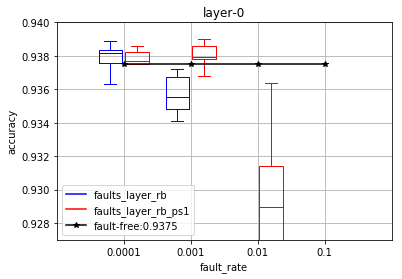

layer_id: 1, #values: 36864
fault_type fault_rate      0      1      2      3      4      5      6      7      8      9
        rb      1e-05 0.9375 0.9378 0.9384 0.9381 0.9378 0.9376 0.9381 0.9375 0.9379 0.9378
        rb     0.0001 0.9377  0.937 0.9375 0.9381  0.938  0.937 0.9371 0.9379 0.9384 0.9373
        rb      0.001 0.9341 0.9279 0.9347 0.9327 0.9354 0.9358 0.9352 0.9313 0.9343 0.9363
        rb       0.01 0.8369  0.815 0.7789 0.8739 0.8768 0.8578  0.858 0.8928 0.8773 0.7631
        rb        0.1 0.1734  0.178 0.1474 0.2344 0.3788 0.2077 0.1772 0.2617 0.2201 0.2373
       ps1      1e-05 0.9375 0.9378 0.9375 0.9391 0.9381 0.9376 0.9377 0.9375 0.9379  0.938
       ps1     0.0001 0.9376 0.9386 0.9388 0.9381  0.938  0.938  0.938 0.9375 0.9387 0.9383
       ps1      0.001 0.9372  0.938 0.9387 0.9379 0.9371 0.9386  0.938 0.9338 0.9373  0.937
       ps1       0.01 0.9332 0.9308 0.9323  0.932 0.9327 0.9263 0.9325 0.9297 0.9257 0.9307
       ps1        0.1 0.8704 0.7846 0.7522  0.828  0

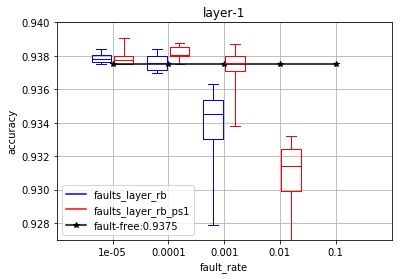

layer_id: 2, #values: 73728
fault_type fault_rate      0      1      2      3      4      5      6      7      8      9
        rb      1e-05 0.9375  0.938 0.9377 0.9386 0.9386 0.9381 0.9382 0.9384 0.9382 0.9384
        rb     0.0001 0.9389 0.9378 0.9378 0.9389  0.938 0.9367 0.9374 0.9382  0.938 0.9377
        rb      0.001 0.9372 0.9354 0.9356  0.936 0.9376 0.9349  0.938 0.9359 0.9379 0.9347
        rb       0.01 0.9239 0.9247 0.9086 0.9251 0.9179 0.9118 0.9229 0.9192 0.9109 0.9136
        rb        0.1 0.3039 0.2587 0.2847 0.3965 0.3288 0.2745 0.5697  0.223 0.3135    0.3
       ps1      1e-05 0.9375  0.938 0.9383 0.9375 0.9373 0.9379 0.9382 0.9381  0.938 0.9391
       ps1     0.0001 0.9382 0.9376  0.938 0.9383 0.9376 0.9381 0.9387 0.9379 0.9376 0.9391
       ps1      0.001 0.9386 0.9387 0.9369 0.9377 0.9376 0.9381 0.9392 0.9372 0.9393 0.9378
       ps1       0.01 0.9363 0.9357 0.9374 0.9361 0.9364 0.9371 0.9366 0.9365  0.937 0.9374
       ps1        0.1 0.9193 0.9095 0.9193 0.9194 0.

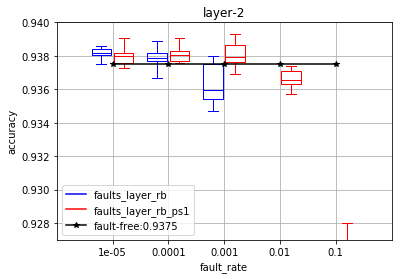

layer_id: 3, #values: 147456
fault_type fault_rate      0      1      2      3      4      5      6      7      8      9
        rb      1e-06 0.9375 0.9377 0.9381 0.9378 0.9376 0.9375 0.9381 0.9381 0.9381 0.9383
        rb      1e-05 0.9381 0.9378 0.9383 0.9386 0.9376 0.9382 0.9386 0.9384 0.9385 0.9383
        rb     0.0001 0.9383 0.9384 0.9377 0.9381 0.9371 0.9381  0.938 0.9386 0.9375 0.9381
        rb      0.001  0.937 0.9366 0.9363 0.9371 0.9382 0.9376 0.9362 0.9378  0.937 0.9355
        rb       0.01 0.9305 0.9271  0.925 0.9328 0.9279  0.931 0.9268 0.9265 0.9236 0.9266
        rb        0.1 0.6298 0.4616 0.6082 0.6163 0.5344 0.6871 0.5382 0.5806  0.587 0.5307
       ps1      1e-06 0.9375 0.9375 0.9375 0.9378 0.9376 0.9375 0.9375 0.9375 0.9381 0.9375
       ps1      1e-05 0.9384 0.9372 0.9378 0.9384 0.9383 0.9374 0.9375 0.9387 0.9384 0.9388
       ps1     0.0001 0.9381 0.9385  0.938 0.9382 0.9388 0.9386 0.9382 0.9383 0.9386  0.938
       ps1      0.001 0.9371  0.937 0.9384 0.9382 0

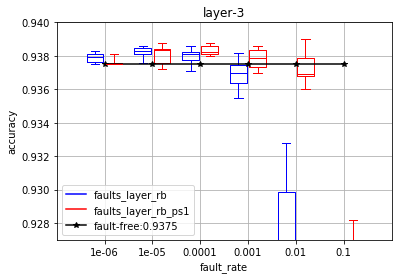

layer_id: 4, #values: 294912
fault_type fault_rate      0      1      2      3      4      5      6      7      8      9
        rb      1e-06 0.9375 0.9377  0.938 0.9377 0.9377 0.9376 0.9378 0.9377 0.9379 0.9377
        rb      1e-05 0.9381 0.9384 0.9387 0.9385  0.938 0.9388 0.9377 0.9376 0.9379 0.9379
        rb     0.0001 0.9373 0.9378 0.9385  0.938 0.9378 0.9375 0.9376 0.9373 0.9377 0.9375
        rb      0.001 0.9337 0.9348 0.9358 0.9349 0.9366 0.9356 0.9355 0.9366 0.9359 0.9354
        rb       0.01 0.8865 0.8774 0.8905 0.8692 0.8871 0.8747  0.881 0.8903 0.8936 0.8961
        rb        0.1 0.1463 0.1617 0.1315 0.1234 0.1357 0.1563 0.1369 0.1603 0.1472 0.1515
       ps1      1e-06 0.9375 0.9377 0.9377 0.9379 0.9378 0.9376 0.9379 0.9377 0.9379 0.9377
       ps1      1e-05 0.9381 0.9382  0.938 0.9382 0.9378 0.9373 0.9376 0.9377 0.9377 0.9375
       ps1     0.0001 0.9379  0.938 0.9383 0.9381 0.9379 0.9377 0.9389 0.9375  0.938 0.9375
       ps1      0.001  0.938 0.9382 0.9378 0.9378 0

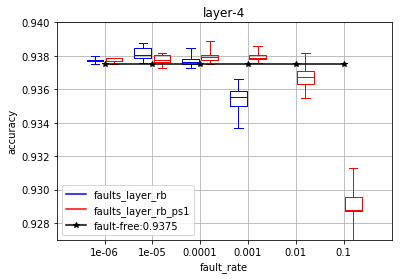

layer_id: 5, #values: 589824
fault_type fault_rate      0      1      2      3      4      5      6      7      8      9
        rb      1e-06 0.9375 0.9376  0.938 0.9374 0.9376  0.938 0.9375 0.9372 0.9375 0.9376
        rb      1e-05 0.9374 0.9377 0.9378 0.9379 0.9378 0.9378 0.9377 0.9374  0.938 0.9371
        rb     0.0001 0.9377 0.9382 0.9383 0.9378 0.9379 0.9384 0.9374 0.9372 0.9375 0.9377
        rb      0.001 0.9367 0.9357 0.9373 0.9366 0.9363  0.938  0.937  0.936 0.9367 0.9373
        rb       0.01 0.9308 0.9293 0.9337 0.9324 0.9326 0.9349 0.9306 0.9312 0.9327 0.9302
        rb        0.1 0.7541 0.7241 0.7798 0.7359 0.7534 0.7822 0.7701 0.7148 0.7629 0.7671
       ps1      1e-06 0.9375 0.9375  0.938 0.9378 0.9378 0.9377 0.9374 0.9373 0.9372 0.9377
       ps1      1e-05 0.9379 0.9379 0.9378 0.9378 0.9376 0.9377 0.9377 0.9377 0.9375 0.9378
       ps1     0.0001 0.9382  0.938 0.9382 0.9375  0.938 0.9378 0.9375 0.9375 0.9379  0.938
       ps1      0.001 0.9379 0.9372 0.9375 0.9367 0

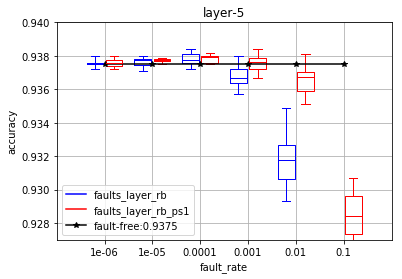

layer_id: 6, #values: 589824
fault_type fault_rate      0      1      2      3      4      5      6      7      8      9
        rb      1e-06 0.9375 0.9373 0.9376 0.9375 0.9379 0.9376 0.9375 0.9377 0.9377 0.9378
        rb      1e-05 0.9382 0.9379 0.9382 0.9378 0.9378 0.9377 0.9376 0.9376  0.938  0.938
        rb     0.0001 0.9384  0.937 0.9373 0.9382 0.9377 0.9374 0.9376 0.9369 0.9381 0.9376
        rb      0.001 0.9362 0.9358 0.9366 0.9356 0.9365 0.9363 0.9367 0.9359 0.9362 0.9363
        rb       0.01 0.9166 0.9208 0.9218 0.9205 0.9228 0.9218 0.9187 0.9259 0.9217 0.9194
        rb        0.1 0.1739 0.2481 0.2766  0.284 0.2973 0.2277 0.2439  0.252 0.2236 0.2129
       ps1      1e-06 0.9375 0.9375 0.9378 0.9377 0.9378 0.9375 0.9377 0.9375 0.9377 0.9377
       ps1      1e-05 0.9377 0.9377 0.9376 0.9379 0.9378  0.938 0.9378 0.9374 0.9374 0.9376
       ps1     0.0001 0.9377 0.9377 0.9374 0.9379  0.938 0.9381  0.938 0.9376  0.938  0.938
       ps1      0.001 0.9376  0.938 0.9376  0.938 0

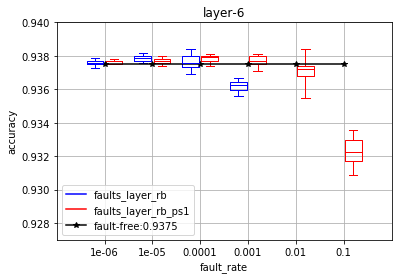

layer_id: 7, #values: 1179648
fault_type fault_rate      0      1      2      3      4      5      6      7      8      9
        rb      1e-06 0.9375 0.9376 0.9377 0.9379 0.9377 0.9377 0.9377 0.9375 0.9378 0.9378
        rb      1e-05 0.9376 0.9374 0.9378 0.9379  0.938 0.9377 0.9379 0.9376 0.9381 0.9379
        rb     0.0001 0.9377 0.9377 0.9383 0.9375 0.9379 0.9373 0.9376 0.9373 0.9381 0.9382
        rb      0.001  0.937 0.9374 0.9368 0.9366 0.9369  0.938 0.9374 0.9369 0.9367  0.938
        rb       0.01 0.9328 0.9326 0.9331 0.9307 0.9323  0.933 0.9326 0.9317 0.9334 0.9308
        rb        0.1 0.1452 0.1534 0.1372 0.1469 0.1459 0.1385 0.1352 0.1623 0.1421 0.1338
       ps1      1e-06 0.9375 0.9376 0.9376 0.9378 0.9374 0.9374 0.9377 0.9375 0.9375 0.9378
       ps1      1e-05 0.9378 0.9377 0.9379 0.9378 0.9377 0.9379 0.9375 0.9377 0.9377  0.938
       ps1     0.0001 0.9376 0.9378 0.9376 0.9377 0.9381 0.9378 0.9373 0.9377 0.9379 0.9378
       ps1      0.001 0.9374 0.9379 0.9378 0.9377 

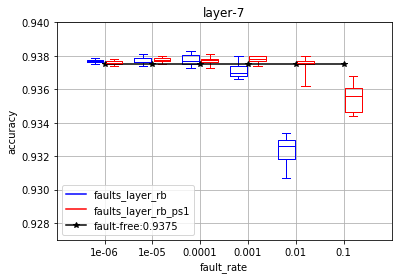

layer_id: 8, #values: 2359296
fault_type fault_rate      0      1      2      3      4      5      6      7      8      9
        rb      1e-07 0.9375 0.9374 0.9377 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375 0.9376
        rb      1e-06 0.9377 0.9376 0.9377 0.9378 0.9375 0.9377 0.9376 0.9376 0.9377 0.9377
        rb      1e-05  0.938 0.9377 0.9378 0.9378 0.9377 0.9376 0.9378 0.9377 0.9377 0.9374
        rb     0.0001 0.9377 0.9375 0.9377 0.9375 0.9377 0.9379 0.9379 0.9379 0.9376 0.9382
        rb      0.001 0.9379 0.9372  0.938 0.9383  0.938 0.9379 0.9375 0.9378  0.938  0.938
        rb       0.01 0.9384 0.9369 0.9382 0.9374 0.9381 0.9376 0.9375 0.9377 0.9368 0.9379
        rb        0.1 0.9337 0.9333 0.9334 0.9331 0.9348 0.9342 0.9333 0.9331 0.9324 0.9343
       ps1      1e-07 0.9375 0.9374 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375 0.9376
       ps1      1e-06 0.9378 0.9377 0.9377 0.9376 0.9377 0.9376 0.9377 0.9376 0.9377 0.9376
       ps1      1e-05 0.9377 0.9376 0.9381 0.9375 

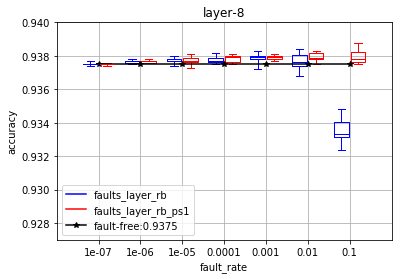

layer_id: 9, #values: 2359296
fault_type fault_rate      0      1      2      3      4      5      6      7      8      9
        rb      1e-07 0.9375 0.9375 0.9374 0.9376 0.9376 0.9375 0.9375 0.9377 0.9375 0.9375
        rb      1e-06 0.9378 0.9377 0.9377 0.9376 0.9377 0.9377 0.9379 0.9377 0.9377 0.9376
        rb      1e-05  0.938 0.9375 0.9379 0.9372 0.9378 0.9375 0.9378 0.9376 0.9377 0.9374
        rb     0.0001 0.9381 0.9378 0.9379 0.9376 0.9378  0.938 0.9376 0.9376 0.9375 0.9379
        rb      0.001  0.938 0.9381  0.938 0.9378 0.9377 0.9377  0.938  0.938 0.9379 0.9379
        rb       0.01 0.9383 0.9382 0.9378 0.9374 0.9375 0.9383 0.9377  0.937 0.9379 0.9385
        rb        0.1 0.9321 0.9339 0.9335 0.9311 0.9338 0.9331 0.9333 0.9336 0.9347 0.9334
       ps1      1e-07 0.9375 0.9375 0.9375 0.9375 0.9376 0.9375 0.9375 0.9375 0.9375 0.9375
       ps1      1e-06 0.9376 0.9376 0.9375 0.9376 0.9376 0.9375 0.9376 0.9376 0.9375 0.9375
       ps1      1e-05 0.9376 0.9376 0.9376 0.9376 

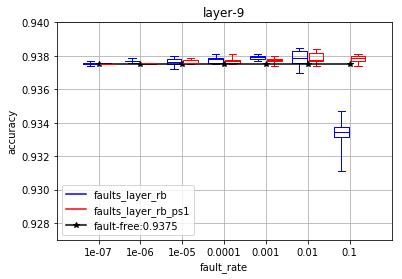

layer_id: 10, #values: 2359296
fault_type fault_rate      0      1      2      3      4      5      6      7      8      9
        rb      1e-07 0.9375 0.9375 0.9375 0.9376 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375
        rb      1e-06 0.9376 0.9377 0.9379 0.9377 0.9377 0.9377 0.9376 0.9376 0.9378 0.9376
        rb      1e-05 0.9376 0.9377 0.9375 0.9377 0.9375 0.9378 0.9377 0.9376 0.9375 0.9376
        rb     0.0001 0.9377 0.9378 0.9377 0.9377 0.9376 0.9377 0.9378 0.9377 0.9379 0.9377
        rb      0.001 0.9376 0.9378 0.9377 0.9378 0.9379 0.9377 0.9375  0.938 0.9377 0.9377
        rb       0.01 0.9379 0.9384 0.9378  0.938 0.9377 0.9377 0.9378 0.9383  0.938  0.938
        rb        0.1 0.9378 0.9376 0.9373 0.9376 0.9367 0.9375 0.9374 0.9375  0.937 0.9377
       ps1      1e-07 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375
       ps1      1e-06 0.9378 0.9375 0.9375 0.9374 0.9375 0.9375 0.9375 0.9376 0.9376 0.9375
       ps1      1e-05 0.9377 0.9375 0.9377 0.9376

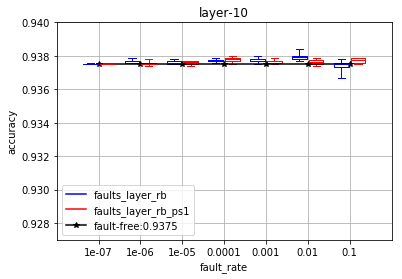

layer_id: 11, #values: 2359296
fault_type fault_rate      0      1      2      3      4      5      6      7      8      9
        rb      1e-07 0.9375 0.9375 0.9375 0.9375 0.9376 0.9375 0.9375 0.9375 0.9375 0.9375
        rb      1e-06 0.9376 0.9376 0.9377 0.9376 0.9378 0.9377 0.9374 0.9376 0.9376 0.9376
        rb      1e-05 0.9378 0.9378 0.9377 0.9375 0.9377 0.9379 0.9376 0.9376 0.9376 0.9378
        rb     0.0001 0.9378 0.9377 0.9377 0.9376 0.9375 0.9377 0.9375 0.9379 0.9375 0.9375
        rb      0.001 0.9374 0.9375 0.9379 0.9377 0.9372 0.9376 0.9377 0.9378 0.9377 0.9374
        rb       0.01 0.9377 0.9372  0.938 0.9379 0.9376 0.9377 0.9377  0.938 0.9378 0.9382
        rb        0.1 0.9373  0.937 0.9372 0.9369 0.9363 0.9375 0.9369 0.9371 0.9375  0.937
       ps1      1e-07 0.9375 0.9375 0.9375 0.9375 0.9376 0.9375 0.9375 0.9375 0.9375 0.9375
       ps1      1e-06 0.9376 0.9375 0.9376 0.9375 0.9376 0.9375 0.9376 0.9375 0.9375 0.9376
       ps1      1e-05 0.9378 0.9377 0.9376 0.9377

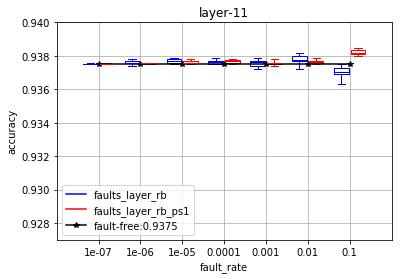

layer_id: 12, #values: 2359296
fault_type fault_rate      0      1      2      3      4      5      6      7      8      9
        rb      1e-07 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375 0.9376 0.9375 0.9375
        rb      1e-06 0.9377 0.9377 0.9376 0.9374 0.9377 0.9377 0.9375 0.9377 0.9374 0.9374
        rb      1e-05 0.9376 0.9373 0.9376 0.9375 0.9377 0.9376 0.9378 0.9378 0.9375 0.9375
        rb     0.0001 0.9375 0.9376 0.9375 0.9378 0.9378 0.9375 0.9376 0.9376 0.9375 0.9377
        rb      0.001  0.938 0.9378 0.9378 0.9378 0.9378 0.9378  0.938 0.9377 0.9375 0.9377
        rb       0.01 0.9381 0.9381 0.9383 0.9384 0.9383 0.9382 0.9379 0.9383  0.939 0.9381
        rb        0.1 0.9374  0.936 0.9367 0.9343 0.9358 0.9353 0.9357 0.9307 0.9332 0.9334
       ps1      1e-07 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375
       ps1      1e-06 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375 0.9374
       ps1      1e-05 0.9377 0.9377 0.9375 0.9375

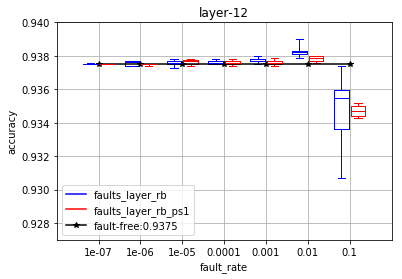

layer_id: 13, #values: 262144
fault_type fault_rate      0      1      2      3      4      5      6      7      8      9
        rb      1e-06 0.9375 0.9377 0.9375 0.9375 0.9375 0.9375 0.9375 0.9376 0.9374 0.9375
        rb      1e-05 0.9376 0.9376 0.9375 0.9377 0.9375 0.9377 0.9377 0.9375 0.9375 0.9374
        rb     0.0001 0.9378 0.9374  0.938 0.9378 0.9377 0.9377 0.9378 0.9375 0.9378  0.938
        rb      0.001 0.9378 0.9376 0.9382 0.9379 0.9379 0.9374 0.9376 0.9375 0.9375 0.9384
        rb       0.01 0.9369  0.937  0.937 0.9344 0.9376 0.9375 0.9372 0.9377 0.9372  0.938
        rb        0.1 0.8423 0.9173 0.9109 0.8296 0.8293 0.9216 0.9309 0.9303 0.8375 0.8272
       ps1      1e-06 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375
       ps1      1e-05 0.9375 0.9375 0.9375 0.9375 0.9375 0.9376 0.9375 0.9375 0.9375 0.9375
       ps1     0.0001 0.9376 0.9374 0.9376 0.9377 0.9376 0.9375 0.9375 0.9377 0.9376 0.9377
       ps1      0.001 0.9379 0.9376 0.9375 0.9377 

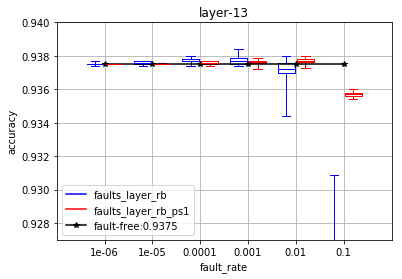

layer_id: 14, #values: 5120
fault_type fault_rate      0      1      2      3      4      5      6      7      8      9
        rb     0.0001 0.9375 0.9376 0.9376 0.9376 0.9373 0.9375 0.9376 0.9375 0.9375 0.9375
        rb      0.001 0.9378 0.9375 0.9377 0.9381 0.9373 0.9379 0.9375 0.9377 0.9377 0.9374
        rb       0.01 0.9388 0.9383  0.938 0.9383 0.9375 0.9377 0.9379  0.938 0.9381 0.9376
        rb        0.1 0.9363 0.9361 0.9343 0.9373   0.93 0.9349 0.9342  0.934 0.9354 0.9365
       ps1     0.0001 0.9375 0.9375 0.9376 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375 0.9375
       ps1      0.001 0.9375 0.9374 0.9376 0.9377 0.9373 0.9376 0.9377 0.9376 0.9377 0.9374
       ps1       0.01 0.9388 0.9385 0.9381 0.9378 0.9376 0.9375 0.9386 0.9374 0.9375 0.9381
       ps1        0.1 0.9377 0.9376  0.937  0.937 0.9337 0.9369 0.9361 0.9371 0.9376 0.9367


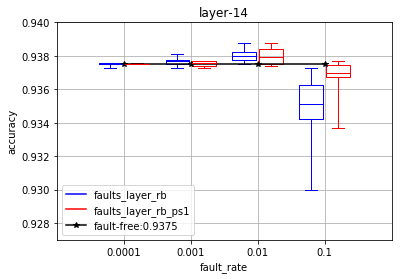

In [8]:
# x: fault_rate, y:accuracy; lengends: param_id 
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    
for param_id in weights_id:
    num_values = np.prod(param_id_to_shape[param_id])
    print('layer_id: %d, #values: %d' %(param_id//3, num_values))
    
    for model_type in model_types:
        fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, model_type)
        fault_rates = sorted(data[model_type][fault_types[0]][param_id].keys())
        colors = ['blue', 'red'] 
        offset = -0.4
        print('%10s %10s %6s %6s %6s %6s %6s %6s %6s %6s %6s %6s' 
              %('fault_type', 'fault_rate', '0', '1', '2', '3', '4', '5' , '6', '7', '8', '9'))
        for i, fault_type in enumerate(fault_types):
            accuracies = [data[model_type][fault_type][param_id][fr][:, 2] for fr in fault_rates]
#             print('fault_type:', fault_type)
            for a, b in zip(fault_rates, accuracies):
                print('%10s %10s %6s %6s %6s %6s %6s %6s %6s %6s %6s %6s' 
              %(fault_type.split('_')[-1], a, *b))
            bpl = plt.boxplot(accuracies, 
                              positions=np.array(range(len(accuracies)))*2.0+offset, 
                              sym='', widths=0.7, whis='range')
            offset += 0.8
            set_box_color(bpl, colors[i]) 
#         print([data[model_type][fault_type][param_id][fr][0, :] for fr in fault_rates])
        
        # draw temporary red and blue lines and use them to create a legend
        for i, fault_type in enumerate(fault_types):
            plt.plot([], c=colors[i], label=fault_type)
        
        x = range(0, len(fault_rates) * 2, 2)
        plt.xticks(x, [str(fault_rate) for fault_rate in fault_rates])

        plt.xlim(-2, len(fault_rates)*2)
        plt.ylim(0.927, 0.94)
        plt.grid()
        plt.ylabel('accuracy')
        plt.xlabel('fault_rate')
        plt.title('layer-%d' %(param_id//3))
        plt.plot(x, [fault_free_accuracy]*len(x), marker='*', color='k', 
                 label='fault-free:%.4f' %(fault_free_accuracy))   
        plt.legend()
        plt.show()
            

In [9]:
import pickle 
def load_pickle(load_path, load_name=None, verbose=False):
    if load_name:
        filepath =  os.path.join(load_path, load_name)
    else:
        filepath = load_path 
    if verbose:
        print('Load pickle file:', filepath)
    return pickle.load( open(filepath, "rb" ))

def parse_stats(stats):
    # input format:
    # stats = {param_name: {value: [(flipped bit position, bit value after flip, value after flip)]}}
    # output format: 
    # param_name: #values changed,  #0 -> 1 bit flips, # 1-> 0 bit flips 
    param_stats = {'changed_params':0, 
                   'flip_to_one': np.zeros(8, dtype='int'), 
                   'flip_to_zero': np.zeros(8, dtype='int'),
                  'value_before_flip': [],
                  'value_after_flip':[], 
                  'flipped_positions': []}
            
    for value_id, flip_list in stats.items():
        param_stats['changed_params'] += 1
        param_stats['value_before_flip'].append(flip_list[0][0])
        param_stats['value_after_flip'].append(flip_list[-1][-1])
        param_stats['flipped_positions'].append([x[1] for x in flip_list])

        for _, flip_pos, flip_bit, flip_value in flip_list:
            if flip_bit:
                param_stats['flip_to_one'][flip_pos] += 1
            else:
                param_stats['flip_to_zero'][flip_pos] += 1
    return param_stats 

def trial_id_to_stats_files(trial_id):
    return str(trial_id)+'.pkl' 

def load_and_average_stats(results_dir, trial_ids):
    stat_dir = os.path.join(results_dir, 'stats')
    stats_files = map(trial_id_to_stats_files, trial_ids)
    avg_param_stats = None 
    for f in stats_files:
        # each trial is saved as a pickle 
        stats = load_pickle(stat_dir, f, verbose=False)
#         print(stats)
         
        param_stats = parse_stats(stats)
        if avg_param_stats:
            for key, value in param_stats.items():
                avg_param_stats[key] += value 
        else:
            avg_param_stats = param_stats
    return avg_param_stats
                    

fault_type: faults_layer_rb
accuracies: [0.9375 0.9378 0.9384 0.9381 0.9378 0.9376 0.9381 0.9375 0.9379 0.9378]
flip_to_one: [3 2 2 4 3 0 1 1], flip_to_zero: [0 1 0 0 0 1 2 0]
#changed_values: 20 , #flipped_bits: 20 , #changed_values: 20 , #flipped_bits: 20
8 [(-2, [1], -66), (5, [1], 69), (1, [2], 33), (4, [1], 68), (12, [0], -116), (5, [0], -123), (40, [0], -88), (5, [2], 37)]
fault_type: faults_layer_rb_ps1
accuracies: [0.9375 0.9378 0.9375 0.9391 0.9381 0.9376 0.9377 0.9375 0.9379 0.938 ]
flip_to_one: [1 1 0 4 3 0 1 1], flip_to_zero: [2 2 2 0 0 1 2 0]
#changed_values: 20 , #flipped_bits: 20 , #changed_values: 20 , #flipped_bits: 20
1 [(40, [0], -88)]


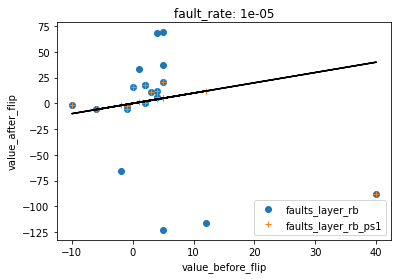

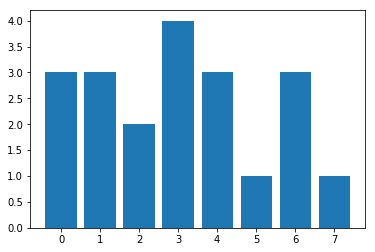

In [30]:

model_type = 'full'
param_id = weights_id[1]
fault_rate = 0.00001
markers = ['o', '+']
for fi, fault_type in enumerate(fault_types):
    print('fault_type:', fault_type)
    print('accuracies:', data[model_type][fault_type][param_id][fault_rate][:, 2])

    folder = 'param-%d/r-%s' %(param_id, fault_rate)
    results_dir = os.path.join(get_results_dir(model_name, dataset_name, model_type, fault_type), folder)

    avg_params_stats = load_and_average_stats(results_dir, range(10)) 
    # print(avg_params_stats)
    print('flip_to_one: %s, flip_to_zero: %s' 
          %(avg_params_stats['flip_to_one'], avg_params_stats['flip_to_zero']))
    
    print('#changed_values:', len(avg_params_stats['value_before_flip']), 
          ', #flipped_bits:', sum(avg_params_stats['flip_to_one'])+sum(avg_params_stats['flip_to_zero']),
         ', #changed_values:', len(avg_params_stats['flipped_positions']),
         ', #flipped_bits:',sum([len(x) for x in avg_params_stats['flipped_positions']]))
    
#     num_values_show = 100 
#     print(list(zip(avg_params_stats['value_before_flip'][:num_values_show], 
#                    avg_params_stats['flipped_positions'][:num_values_show],
#                    avg_params_stats['value_after_flip'][:num_values_show])))

    check = [(avg_params_stats['value_before_flip'][i], 
                  avg_params_stats['flipped_positions'][i], 
                 avg_params_stats['value_after_flip'][i]) 
             for i, item in enumerate(avg_params_stats['flipped_positions'])
                                     if (0 in item or 1 in item or 2 in item) and 
            avg_params_stats['value_before_flip'][i]!=avg_params_stats['value_after_flip'][i]]
    print(len(check), check)
    
    plt.plot(avg_params_stats['value_before_flip'], avg_params_stats['value_after_flip'], 
             marker=markers[fi], label=fault_type, linestyle='')
    plt.xlabel('value_before_flip')
    plt.ylabel('value_after_flip')
    
    
plt.plot(avg_params_stats['value_before_flip'], avg_params_stats['value_before_flip'], 'k-')
plt.legend()
plt.title('fault_rate: %s' %(fault_rate))
plt.show()

import collections 
counter = collections.Counter([x for y in avg_params_stats['flipped_positions'] for x in y ])
counts = sorted(counter.items(), key=lambda x: x[0])
counts = list(zip(*counts))
plt.bar(counts[0], counts[1])
plt.show()
             
                               

In [11]:
# import torch 

# model_path = './logs/vgg16/cifar10/int8/quantized.pth.tar'
# checkpoint = torch.load(model_path)
# prec1 = checkpoint['prec1']
# print('prec1:', prec1)
# state_dict = checkpoint['state_dict']
# for key in state_dict:
#     tensor = state_dict[key]
#     if len(tensor.size()) < 2:
#         continue
#     minv, maxv = tensor.min().item(), tensor.max().item() 
#     plt.hist(tensor.cpu().numpy().ravel(), bins=100)
#     plt.title(key+' [%d, %d]' %(minv, maxv))
#     plt.show()